# 1. Explore The Data: What Data Are We Using?
This dataset dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The 'target' field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease. Using the information about patients, the challenge is to build a model to predict which people would have heart disease based on the following fields:
- **age:** (int) - Age in years
- **sex:** (int) - (1 = Male, 0 = Female)
- **cp:** (int) - Chest pain type
- **trestbps:** (int) - Resting Blood Pressure (in mm Hg on Admission to the Hospital)
- **chol:** (int) - Serum cholestoral in mg/dl
- **fbs:** (int) - Fasting blood sugar >120 mg/dl (1 = True, 0 = False)
- **restecg:** (int) - Resting electrocardiographic results
- **thalach:** (int) - Maximum heart rate achieved
- **exang:** (int) - Exercise induced angina (1 = yes, 0 = no)
- **oldpeak:** (float) - ST depression induced by exercise relative to rest
- **slope:** (int) - The slope of the peak exercise ST segment
- **ca:** (int) - Number of major vessels (0-3) colored by flourosopy
- **thal:** (int) - A blood disorder called thalassemia (3 = Normal, 6 = Fixed Defect, 7 = Reversable Defect)

### Read In Data

In [1]:
# Read in the data
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from time import time
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

heart = pd.read_csv("/kaggle/input/heart-disease-dataset/heart.csv")

In [2]:
# Check the number of rows and columns in the data
heart.shape

(1025, 14)

In [3]:
# Check the type of data stored in each column
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# Look at the general distribution of features
heart.describe().T

count        mean        std    min    25%    50%    75%    max
age       1025.0   54.434146   9.072290   29.0   48.0   56.0   61.0   77.0
sex       1025.0    0.695610   0.460373    0.0    0.0    1.0    1.0    1.0
cp        1025.0    0.942439   1.029641    0.0    0.0    1.0    2.0    3.0
trestbps  1025.0  131.611707  17.516718   94.0  120.0  130.0  140.0  200.0
chol      1025.0  246.000000  51.592510  126.0  211.0  240.0  275.0  564.0
fbs       1025.0    0.149268   0.356527    0.0    0.0    0.0    0.0    1.0
restecg   1025.0    0.529756   0.527878    0.0    0.0    1.0    1.0    2.0
thalach   1025.0  149.114146  23.005724   71.0  132.0  152.0  166.0  202.0
exang     1025.0    0.336585   0.472772    0.0    0.0    0.0    1.0    1.0
oldpeak   1025.0    1.071512   1.175053    0.0    0.0    0.8    1.8    6.2
slope     1025.0    1.385366   0.617755    0.0    1.0    1.0    2.0    2.0
ca        1025.0    0.754146   1.030798    0.0    0.0    0.0    1.0    4.0
thal      1025.0    2.323902   0.620660    0.0    2.0    2.0    3.0    3.0
target    1025.0    0.513171   0.500070    0.0    0.0    1.0    1.0    1.0

In [5]:
# Look at the correlation matrix
heart.corr()

age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.103240 -0.071966  0.271121  0.219823  0.121243   
sex      -0.103240  1.000000 -0.041119 -0.078974 -0.198258  0.027200   
cp       -0.071966 -0.041119  1.000000  0.038177 -0.081641  0.079294   
trestbps  0.271121 -0.078974  0.038177  1.000000  0.127977  0.181767   
chol      0.219823 -0.198258 -0.081641  0.127977  1.000000  0.026917   
fbs       0.121243  0.027200  0.079294  0.181767  0.026917  1.000000   
restecg  -0.132696 -0.055117  0.043581 -0.123794 -0.147410 -0.104051   
thalach  -0.390227 -0.049365  0.306839 -0.039264 -0.021772 -0.008866   
exang     0.088163  0.139157 -0.401513  0.061197  0.067382  0.049261   
oldpeak   0.208137  0.084687 -0.174733  0.187434  0.064880  0.010859   
slope    -0.169105 -0.026666  0.131633 -0.120445 -0.014248 -0.061902   
ca        0.271551  0.111729 -0.176206  0.104554  0.074259  0.137156   
thal      0.072297  0.198424 -0.163341  0.059276  0.100244 -0.042177   
target   -0.229324 -0.279501  0.434854 -0.138772 -0.099966 -0.041164   

           restecg   thalach     exang   oldpeak     slope        ca  \
age      -0.132696 -0.390227  0.088163  0.208137 -0.169105  0.271551   
sex      -0.055117 -0.049365  0.139157  0.084687 -0.026666  0.111729   
cp        0.043581  0.306839 -0.401513 -0.174733  0.131633 -0.176206   
trestbps -0.123794 -0.039264  0.061197  0.187434 -0.120445  0.104554   
chol     -0.147410 -0.021772  0.067382  0.064880 -0.014248  0.074259   
fbs      -0.104051 -0.008866  0.049261  0.010859 -0.061902  0.137156   
restecg   1.000000  0.048411 -0.065606 -0.050114  0.086086 -0.078072   
thalach   0.048411  1.000000 -0.380281 -0.349796  0.395308 -0.207888   
exang    -0.065606 -0.380281  1.000000  0.310844 -0.267335  0.107849   
oldpeak  -0.050114 -0.349796  0.310844  1.000000 -0.575189  0.221816   
slope     0.086086  0.395308 -0.267335 -0.575189  1.000000 -0.073440   
ca       -0.078072 -0.207888  0.107849  0.221816 -0.073440  1.000000   
thal     -0.020504 -0.098068  0.197201  0.202672 -0.094090  0.149014   
target    0.134468  0.422895 -0.438029 -0.438441  0.345512 -0.382085   

              thal    target  
age       0.072297 -0.229324  
sex       0.198424 -0.279501  
cp       -0.163341  0.434854  
trestbps  0.059276 -0.138772  
chol      0.100244 -0.099966  
fbs      -0.042177 -0.041164  
restecg  -0.020504  0.134468  
thalach  -0.098068  0.422895  
exang     0.197201 -0.438029  
oldpeak   0.202672 -0.438441  
slope    -0.094090  0.345512  
ca        0.149014 -0.382085  
thal      1.000000 -0.337838  
target   -0.337838  1.000000

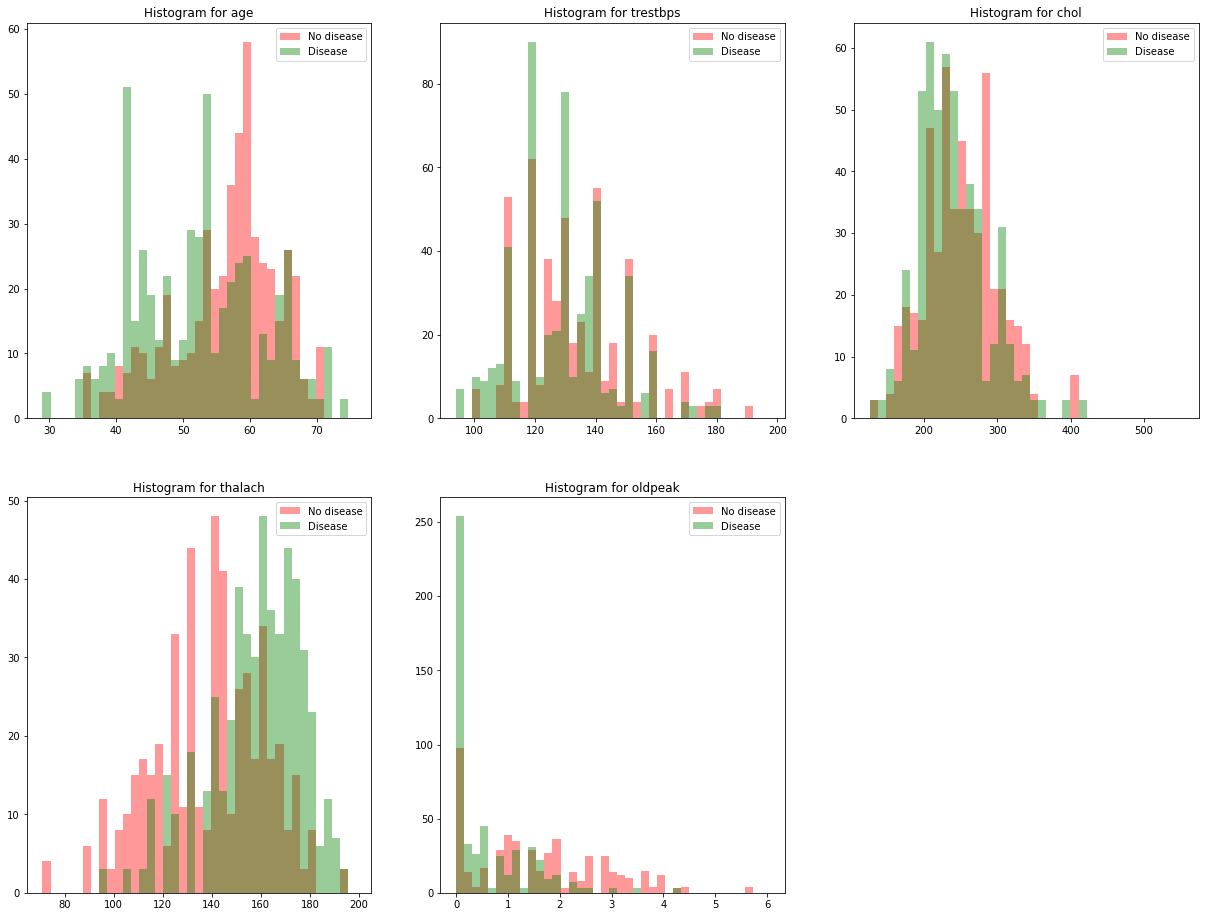

In [6]:
# Plot overlaid histograms for continuous features
plt.figure(figsize=(21,16))
col = 1

for i in ["age","trestbps","chol","thalach","oldpeak"]:
    if col<6:
        plt.subplot(2,3,col)
        no_disease = list(heart[heart["target"]==0][i])
        disease = list(heart[heart["target"]==1][i])
        xmin = min(min(no_disease),min(disease))
        xmax = max(max(no_disease),max(disease))
        width = (xmax-xmin)/40
        sns.distplot(no_disease, color="r", kde=False, bins=np.arange(xmin,xmax,width))
        sns.distplot(disease, color="g", kde=False, bins=np.arange(xmin,xmax,width))
        plt.legend(["No disease","Disease"])
        plt.title("Histogram for %s" % (i))
    col += 1

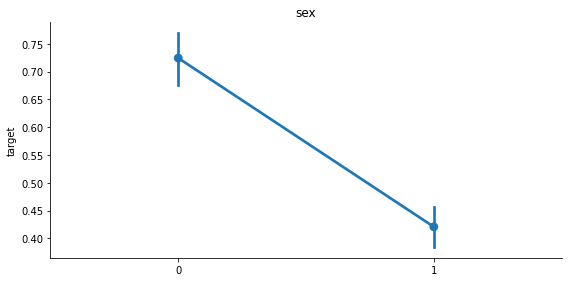

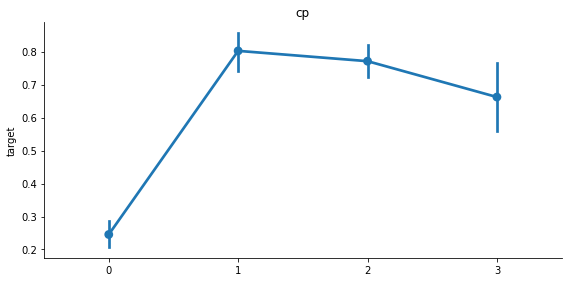

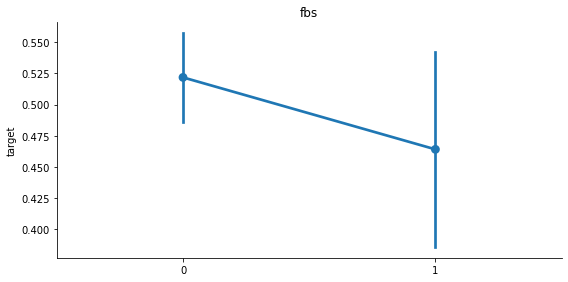

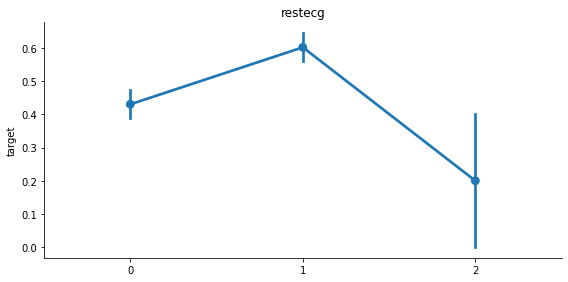

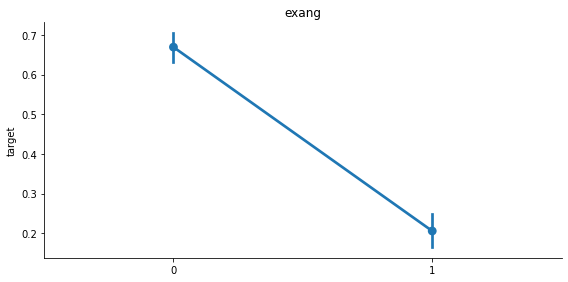

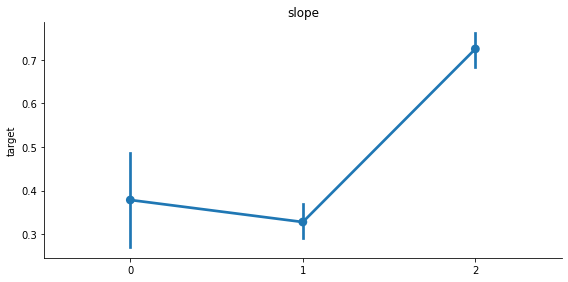

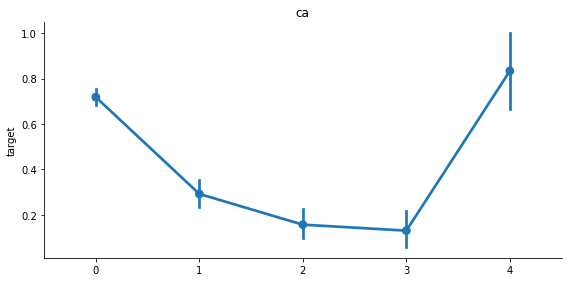

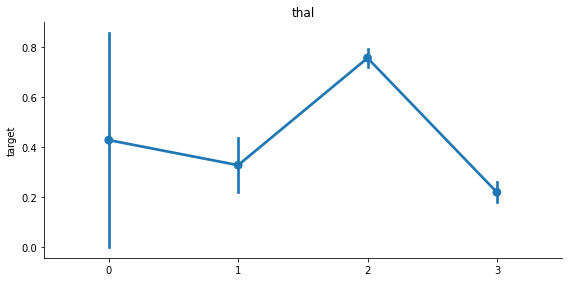

In [7]:
# Generate categorical plots for ordinal features
for col in ["sex","cp","fbs","restecg","exang","slope","ca","thal"]:
    sns.catplot(x=col, y="target", data=heart, kind="point", height=4, aspect=2).set(xlabel=None)
    plt.title(col)

After a quick glimpse of the dataset to get an initial understanding of the variables and their formats, the next step is to check for the number of missing values in each column.
# 2. Data Cleaning

In [8]:
# Check where we have missing values
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

There are no missing values.
# 3. Data Analysis
### See the distribution of our target variable

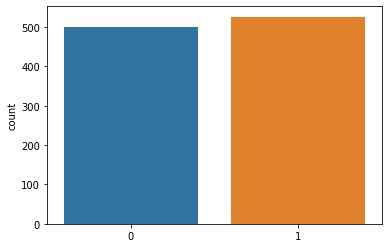

In [9]:
sns.countplot(x="target", data=heart).set(xlabel=None);

- **526** patients are having heart disease.
- The ratio between **1** and **0** is much less than **1.5** which indicates that the target feature is not imbalanced.

### Minimum, maximum & average age of the persons having heart disease

In [10]:
round(heart.groupby(["target"])["age"].agg(["min","max","mean"]),2)

min  max   mean
target                 
0        35   77  56.57
1        29   76  52.41

### Distribution of ages

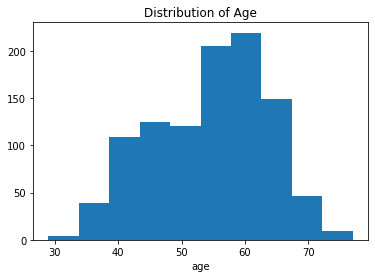

In [11]:
plt.hist(heart["age"])
plt.title("Distribution of Age")
plt.xlabel("age");

### How age is related with heart disease?

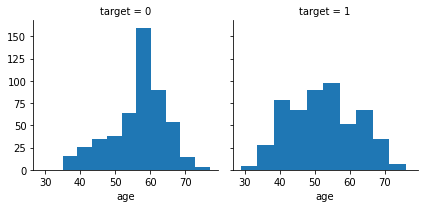

In [12]:
g = sns.FacetGrid(data=heart[heart["age"].notna()], col="target")
g.map(plt.hist, "age");

- Mostly patients are having age between **40-70**.

### What is the ratio of male and female patients?

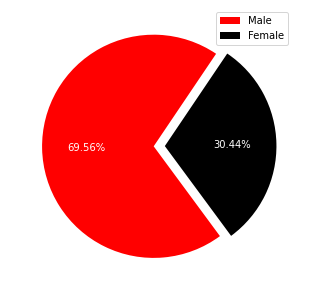

In [13]:
plt.figure(figsize=(5,7))
sex = ["Male","Female"]
values = heart["sex"].value_counts()
color = ["red","black"]
plt.pie(values, labels=sex, colors=color, explode=(0,0.1), autopct="%.2f%%", textprops={"color":"w"}, startangle=56)
plt.legend();

- Ratio of male to female patients is approx **2:1**.

### How sex is related with heart disease?

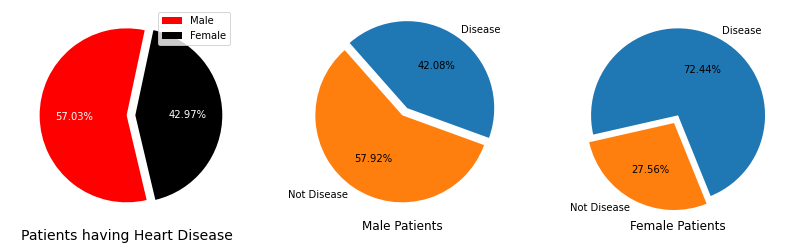

In [14]:
plt.figure(figsize=(14,4))
labels = ["Disease","Not Disease"]
sex = ["Male","Female"]
male = heart[heart["sex"]==1]["target"].value_counts().sort_values(ascending=True)
female = heart[heart["sex"]==0]["target"].value_counts()
paitients = heart[heart["target"]==1]["sex"].value_counts()
color = ["red","black"]

plt.subplot(1,3,1)
plt.pie(paitients, labels=sex, colors=color, explode=(0,0.1), autopct="%.2f%%", textprops={"color":"w"}, startangle=78)
plt.title("Patients having Heart Disease", y=-0.1, fontsize=14)
plt.legend()

plt.subplot(1,3,2)
plt.pie(male, labels=labels, explode=(0.1,0), autopct="%.2f%%", startangle=-20)
plt.title("Male Patients", y=-0.05)

plt.subplot(1,3,3)
plt.pie(female, labels=labels, explode=(0,0.1), autopct="%.2f%%", startangle=-68)
plt.title("Female Patients", y=-0.05);

### How does sex affect angina?

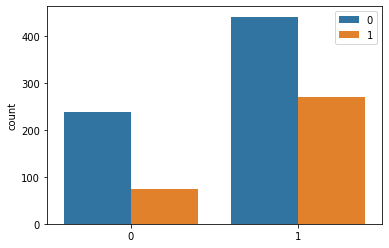

In [15]:
sns.countplot(x="sex", data=heart, hue="exang").set(xlabel=None)
plt.legend(loc="upper right");

- Although the prevalence of angina in female patients is increasing, female patients are less likely than male patients to undergo invasive management of coronary disease.

### Is sex a risk factor for coronary artery disease?

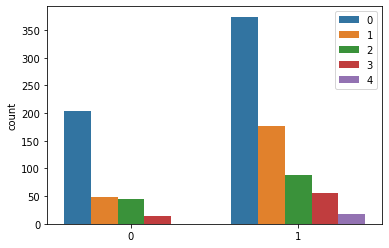

In [16]:
sns.countplot(x="sex", data=heart, hue="ca").set(xlabel=None)
plt.legend(loc="upper right");

- Male patients have a higher propensity of developing ca (coronary artery disease) than female patients.

### What are the different types of chest pain?

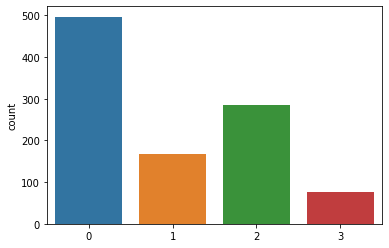

In [17]:
sns.countplot(x="cp", data=heart).set(xlabel=None);

- **0: Typical Angina:** - chest pain related decrease blood supply to the heart
- **1: Atypical Angina:** - chest pain not related to heart
- **2: Non-Anginal Pain:** - typically esophageal spasms (non heart related)
- **3: Asymptomatic:** - chest pain not showing signs of disease

### Who is more prone to chest pain male or female patients?

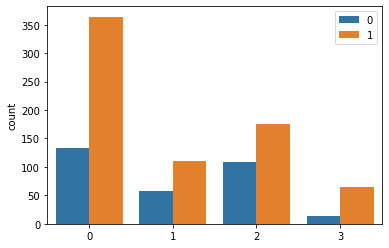

In [18]:
sns.countplot(x="cp", data=heart, hue="sex").set(xlabel=None)
plt.legend(loc="upper right");

- Male patients are more prone to chest pain.
- Most of the patients are having typical angina chest pain.

### How chest pain is related with heart disease?

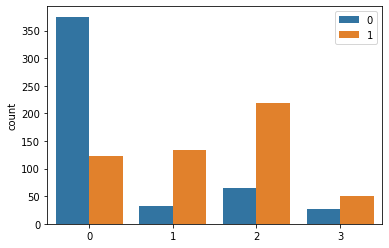

In [19]:
sns.countplot(x="cp", data=heart, hue="target").set(xlabel=None)
plt.legend(loc="upper right");

- Patients having the typical angina pain are less likely to have heart disease.
- Patients having non-anginal pain are likely to have heart disease.

### How blood pressure is related with heart disease?

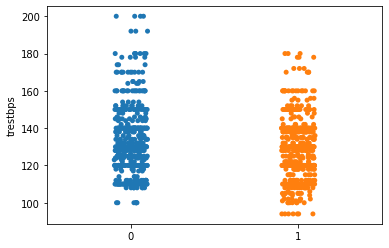

In [20]:
sns.stripplot(x="target", y="trestbps", data=heart).set(xlabel=None);

- Patients having blood pressure between **120 - 140** are more likely to have a heart disease.

### Do male and female patients absorb fasting blood sugar differently?

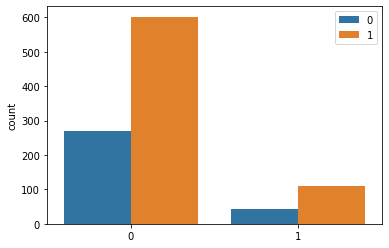

In [21]:
sns.countplot(x="fbs", data=heart, hue="sex").set(xlabel=None)
plt.legend(loc="upper right");

- Female patients have lower fasting blood sugar than male patients.

### How electrocardiographic is relation with heart disease?
- 0: Normal
- 1: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of >0.05 mV)
- 2: Showing probable or definite left ventricular hypertrophy

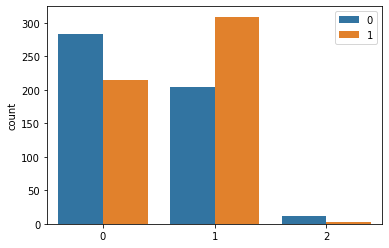

In [22]:
sns.countplot(x="restecg", data=heart, hue="target").set(xlabel=None)
plt.legend(loc="upper right");

- Patients having ST-T wave abnormality resting electrocardiographic are more likely to have heart disease.

### Sex related differences in electrocardiographic parameters

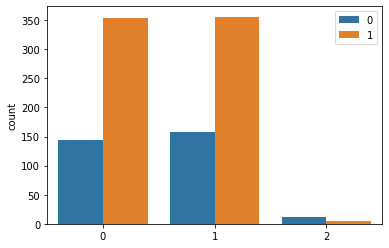

In [23]:
sns.countplot(x="restecg", data=heart, hue="sex").set(xlabel=None)
plt.legend(loc="upper right");

### How thalach is related with target?

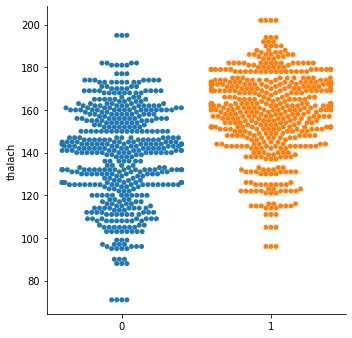

In [24]:
sns.catplot(x="target", y="thalach", data=heart, kind="swarm").set(xlabel=None);

- Patients having heart rate between **140** to **180** are more likely to have a heart disease.

### How agina is related with heart disease?

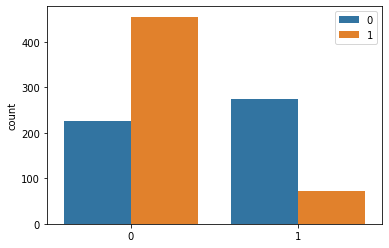

In [25]:
sns.countplot(x="exang", data=heart, hue="target").set(xlabel=None)
plt.legend(loc="upper right");

- Patients having exercise induced angina are less likely to have heart disease.

### Relation between slope and sex

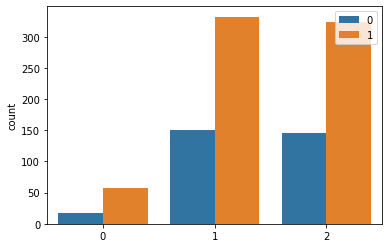

In [26]:
sns.countplot(x="slope", data=heart, hue="sex").set(xlabel=None)
plt.legend(loc="upper right");

- The slope value is higher in the case of male patient.

### Thalassemia
- 0: Null
- 1: Normal blood flow
- 2: Fixed defect (no blood flow in some part of the heart)
- 3: Reversible defect (a blood flow is observed but it is not normal)

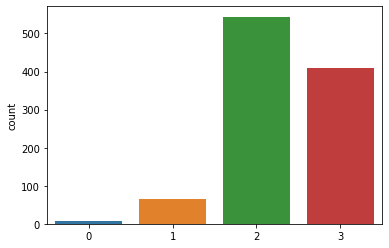

In [27]:
sns.countplot(x="thal", data=heart).set(xlabel=None);

### How thalassemia is related with heart disease?

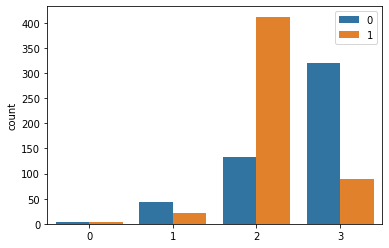

In [28]:
sns.countplot(x="thal", data=heart, hue="target").set(xlabel=None)
plt.legend(loc="upper right");

### Is thalassemia more common in male or female patient?

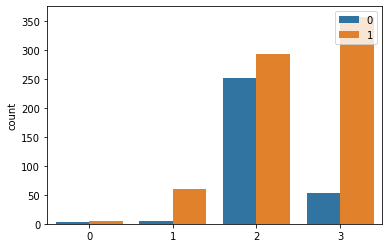

In [29]:
sns.countplot(x="thal", data=heart, hue="sex").set(xlabel=None)
plt.legend(loc="upper right");

- Thalassemia can affect both **male** and **female** patients.
- **Male** patient are more frequently affected than **female** patients.

# 4. Data Preparation
### Cap And Floor Data To Remove Outliers

In [30]:
# See where outliers might be an issue
heart.describe().T

count        mean        std    min    25%    50%    75%    max
age       1025.0   54.434146   9.072290   29.0   48.0   56.0   61.0   77.0
sex       1025.0    0.695610   0.460373    0.0    0.0    1.0    1.0    1.0
cp        1025.0    0.942439   1.029641    0.0    0.0    1.0    2.0    3.0
trestbps  1025.0  131.611707  17.516718   94.0  120.0  130.0  140.0  200.0
chol      1025.0  246.000000  51.592510  126.0  211.0  240.0  275.0  564.0
fbs       1025.0    0.149268   0.356527    0.0    0.0    0.0    0.0    1.0
restecg   1025.0    0.529756   0.527878    0.0    0.0    1.0    1.0    2.0
thalach   1025.0  149.114146  23.005724   71.0  132.0  152.0  166.0  202.0
exang     1025.0    0.336585   0.472772    0.0    0.0    0.0    1.0    1.0
oldpeak   1025.0    1.071512   1.175053    0.0    0.0    0.8    1.8    6.2
slope     1025.0    1.385366   0.617755    0.0    1.0    1.0    2.0    2.0
ca        1025.0    0.754146   1.030798    0.0    0.0    0.0    1.0    4.0
thal      1025.0    2.323902   0.620660    0.0    2.0    2.0    3.0    3.0
target    1025.0    0.513171   0.500070    0.0    0.0    1.0    1.0    1.0

In [31]:
def detect_outlier(feature):
    outliers = []
    data = heart[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y-mean)/std 
        if np.abs(z_score)>3:
            outliers.append(y)
    print("\nOutlier caps for %s:" % (feature))
    print("  -95p: %.1f / %s values exceed that" % (data.quantile(.95),len([i for i in data if i>data.quantile(.95)])))
    print("  -3sd: %.1f / %s values exceed that" % (mean+3*(std),len(outliers)))
    print("  -99p: %.1f / %s values exceed that" % (data.quantile(.99),len([i for i in data if i>data.quantile(.99)])))

In [32]:
# Determine what the upperbound should be for continuous features
for feat in ["age","trestbps","chol","thalach","oldpeak"]:
    detect_outlier(feat)


Outlier caps for age:
  -95p: 68.0 / 43 values exceed that
  -3sd: 81.6 / 0 values exceed that
  -99p: 71.0 / 9 values exceed that

Outlier caps for trestbps:
  -95p: 163.2 / 52 values exceed that
  -3sd: 184.1 / 7 values exceed that
  -99p: 180.0 / 7 values exceed that

Outlier caps for chol:
  -95p: 330.0 / 45 values exceed that
  -3sd: 400.7 / 13 values exceed that
  -99p: 407.0 / 9 values exceed that

Outlier caps for thalach:
  -95p: 182.0 / 35 values exceed that
  -3sd: 218.1 / 4 values exceed that
  -99p: 192.0 / 10 values exceed that

Outlier caps for oldpeak:
  -95p: 3.4 / 51 values exceed that
  -3sd: 4.6 / 7 values exceed that
  -99p: 4.4 / 11 values exceed that


In [33]:
# Cap features
heart["age"].clip(upper=heart["age"].quantile(.99), inplace=True)
heart["trestbps"].clip(upper=heart["trestbps"].quantile(.99), inplace=True)
heart["chol"].clip(upper=heart["chol"].quantile(.99), inplace=True)
heart["thalach"].clip(upper=heart["thalach"].quantile(.99), inplace=True)
heart["oldpeak"].clip(upper=heart["oldpeak"].quantile(.99), inplace=True)

In [34]:
# Describe the dataframe again to make sure the capping was successful
heart.describe().T

count        mean        std    min    25%    50%    75%      max
age       1025.0   54.393171   8.985587   29.0   48.0   56.0   61.0   71.000
sex       1025.0    0.695610   0.460373    0.0    0.0    1.0    1.0    1.000
cp        1025.0    0.942439   1.029641    0.0    0.0    1.0    2.0    3.000
trestbps  1025.0  131.498537  17.142790   94.0  120.0  130.0  140.0  180.000
chol      1025.0  245.505366  49.290931  126.0  211.0  240.0  275.0  407.000
fbs       1025.0    0.149268   0.356527    0.0    0.0    0.0    0.0    1.000
restecg   1025.0    0.529756   0.527878    0.0    0.0    1.0    1.0    2.000
thalach   1025.0  149.060488  22.895957   71.0  132.0  152.0  166.0  192.000
exang     1025.0    0.336585   0.472772    0.0    0.0    0.0    1.0    1.000
oldpeak   1025.0    1.061046   1.138335    0.0    0.0    0.8    1.8    4.352
slope     1025.0    1.385366   0.617755    0.0    1.0    1.0    2.0    2.000
ca        1025.0    0.754146   1.030798    0.0    0.0    0.0    1.0    4.000
thal      1025.0    2.323902   0.620660    0.0    2.0    2.0    3.0    3.000
target    1025.0    0.513171   0.500070    0.0    0.0    1.0    1.0    1.000

### Transform Skewed Features

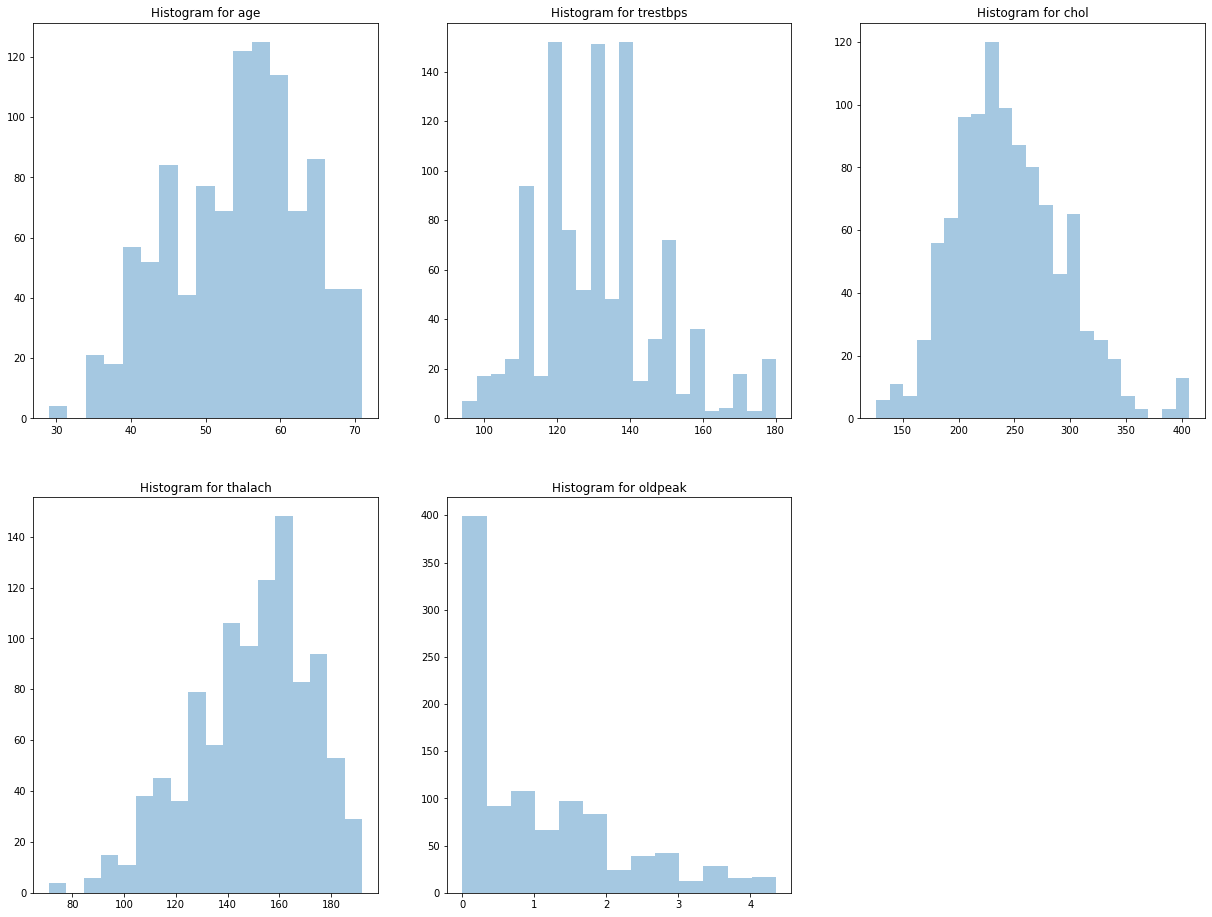

In [35]:
# Plot histogram for each continuous feature to see if a transformation is necessary
plt.figure(figsize=(21,16))
col = 1

for feature in ["age","trestbps","chol","thalach","oldpeak"]:
    if col<6:
        plt.subplot(2,3,col)
        sns.distplot(heart[feature], kde=False).set(xlabel=None)
        plt.title("Histogram for %s" % (feature))
    col += 1

##### Box-Cox Power Transformation

In [36]:
# Transformed feature
heart["age"] = heart["age"].apply(lambda x:x**(1/.7))
heart["trestbps"] = heart["trestbps"].apply(lambda x:x**(1/9))
heart["chol"] = heart["chol"].apply(lambda x:x**(1/2))
heart["thalach"] = heart["thalach"].apply(lambda x:x**(1/.5))
heart["oldpeak"] = heart["oldpeak"].apply(lambda x:x**(1/1.7))

# 5. Model Implementation
### Split Into Train, Validation, And Test Set

In [37]:
# Drop unnecccessary features and split into training/test sets
X = heart.drop(["target"], axis=1)
y = heart["target"]
kf = KFold(n_splits=5)

for train_index,test_index in kf.split(X):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]
    X_val,X_test,y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Standardize Features

In [38]:
# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [39]:
# Scale the training, test, and validation sets
features = X_train.columns

X_train[features] = scaler.transform(X_train)
X_val[features] = scaler.transform(X_val)
X_test[features] = scaler.transform(X_test)

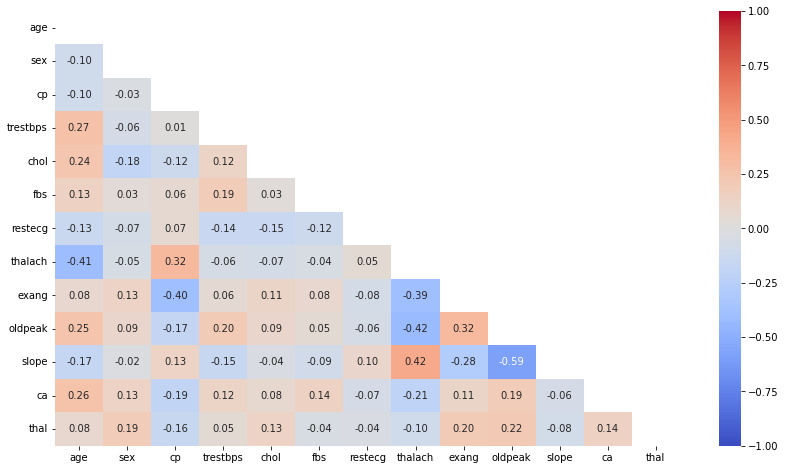

In [40]:
# Generate correlation matrix heat map
plt.figure(figsize=(14,8))
matrix = np.triu(X_train[features].corr())
sns.heatmap(X_train[features].corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cmap="coolwarm", mask=matrix);

Target variable is not highly correlated with any other feature. So, I take all the features for model implementation.
### Logistic Regression

In [41]:
# Conduct search for best params while running cross-validation (GridSearchCV)
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "penalty":["l1","l2","elasticnet",None],
    "solver":["newton-cg","lbfgs","liblinear","sag","saga"]
}

lr_cv = GridSearchCV(LogisticRegression(), parameters, cv=5)
lr_cv.fit(X_train[features],y_train.values.ravel())

lr = lr_cv.best_estimator_
lr.fit(X_train[features],y_train.values.ravel())

LogisticRegression(C=0.1, solver='newton-cg')

### Decision Tree

In [42]:
parameters = {
    "criterion":["gini","entropy"],
    "max_depth":[2,4,8,16,32],
    "min_samples_leaf":[2,4,8,16,32],
    "min_samples_split":[2,4,8,16,32]
}

dt_cv = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
dt_cv.fit(X_train[features],y_train.values.ravel())

dt = dt_cv.best_estimator_
dt.fit(X_train[features],y_train.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2)

### Random Forest

In [43]:
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

rf_cv = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
rf_cv.fit(X_train[features],y_train.values.ravel())

rf = rf_cv.best_estimator_
rf.fit(X_train[features],y_train.values.ravel())

RandomForestClassifier(max_depth=32, n_estimators=50)

### Adaptive Boosting

In [44]:
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
ada_cv.fit(X_train[features],y_train.values.ravel())

ada = ada_cv.best_estimator_
ada.fit(X_train[features],y_train.values.ravel())

AdaBoostClassifier(n_estimators=500)

### Gradient Boosting

In [45]:
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

gb_cv = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5)
gb_cv.fit(X_train[features],y_train.values.ravel())

gb = gb_cv.best_estimator_
gb.fit(X_train[features],y_train.values.ravel())

GradientBoostingClassifier(learning_rate=0.01, max_depth=8, n_estimators=500)

### Extreme Gradient Boosting

In [46]:
parameters = {
    "early_stopping_rounds":[5,10],
    "eval_metric":["auc","aucpr","error"],
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

xgb_cv = GridSearchCV(XGBClassifier(), parameters, cv=5)
xgb_cv.fit(X_train[features],y_train.values.ravel(), eval_set=[(X_val[features],y_val)], verbose=None)

xgb = xgb_cv.best_estimator_
xgb.fit(X_train[features],y_train.values.ravel(), eval_set=[(X_val[features],y_val)], verbose=None)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Light Gradient Boosting Machine

In [47]:
parameters = {  
    "boosting_type":["gbdt","dart","goss","rf"],
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

lgbm_cv = GridSearchCV(LGBMClassifier(), parameters, cv=5)
lgbm_cv.fit(X_train[features],y_train.values.ravel())

lgbm = lgbm_cv.best_estimator_
lgbm.fit(X_train[features],y_train.values.ravel())

LGBMClassifier(learning_rate=1.0, max_depth=16, n_estimators=50)

### K-Nearest Neighbor

In [48]:
parameters = {
    "algorithm":["ball_tree","kd_tree","brute"],
    "metric":["minkowski","euclidean","manhattan"],
    "n_neighbors":range(2,21),
    "weights":["uniform","distance"]
}

knn_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn_cv.fit(X_train[features],y_train.values.ravel())

knn = knn_cv.best_estimator_
knn.fit(X_train[features],y_train.values.ravel())

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=14,
                     weights='distance')

### Support Vector Machine

In [49]:
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svc_cv = GridSearchCV(SVC(), parameters, cv=5)
svc_cv.fit(X_train[features],y_train.values.ravel())

svc = svc_cv.best_estimator_
svc.fit(X_train[features],y_train.values.ravel())

SVC(C=100, kernel='poly')

### Multi-layer Perceptron

In [50]:
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(MLPClassifier(), parameters, cv=5)
mlp_cv.fit(X_train[features],y_train.values.ravel())

mlp = mlp_cv.best_estimator_
mlp.fit(X_train[features],y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              solver='lbfgs')

### Stacking

In [51]:
estimators = [("lr",lr),("dt",dt),("rf",rf),("ada",ada),("gb",gb),("lgbm",lgbm),("knn",knn),("svc",svc),("mlp",mlp)]
parameters = {
    "passthrough":[True,False]
}

sc_cv = GridSearchCV(StackingClassifier(estimators=estimators, final_estimator=lr_cv.best_estimator_), parameters, cv=5)
sc_cv.fit(X_train[features],y_train.values.ravel())

sc = sc_cv.best_estimator_
sc.fit(X_train[features],y_train.values.ravel())

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, solver='newton-cg')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=16,
                                                       min_samples_leaf=2)),
                               ('rf',
                                RandomForestClassifier(max_depth=32,
                                                       n_estimators=50)),
                               ('ada', AdaBoostClassifier(n_estimators=500)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.01,
                                                           max_depth=8,
                                                           n_estimators=50...
                                LGBMClassifier(learning_rate=1.0, max_depth=16,
                

### Evaluate Models On The Validation Set

In [52]:
# Evaluate all of our models on the validation set
models = [lr,dt,rf,ada,gb,xgb,lgbm,knn,svc,mlp,sc]
val_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(X_val[features])
        end = time()        
        temp = pd.DataFrame(
                {
                    "Accuracy":("%0.3f" % (accuracy_score(y_val,pred))),
                    "F1":("%0.3f" % (f1_score(y_val,pred))),
                    "Precision":("%0.3f" % (precision_score(y_val,pred))),
                    "Recall":("%0.3f" % (recall_score(y_val,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[str(i).split("Classifier")[0].split("(")[0]]
        )
        val_set = pd.concat([val_set,temp])
val_set

Accuracy     F1 Precision Recall Latency
LogisticRegression    0.814  0.816     0.764  0.875   0.0ms
DecisionTree          0.980  0.979     1.000  0.958   2.0ms
RandomForest          0.971  0.970     0.941  1.000   9.0ms
AdaBoost              0.961  0.959     0.940  0.979  69.0ms
GradientBoosting      0.971  0.970     0.941  1.000   5.0ms
XGB                   0.941  0.938     0.938  0.938   3.0ms
LGBM                  0.971  0.970     0.941  1.000   2.0ms
KNeighbors            0.971  0.970     0.941  1.000   5.0ms
SVC                   0.971  0.970     0.941  1.000   3.0ms
MLP                   0.971  0.970     0.941  1.000   2.0ms
Stacking              0.971  0.970     0.941  1.000  92.0ms

### Evaluate Best Model On Test Set

In [53]:
# Evaluate our final model on the test set
test_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(X_test[features])
        end = time()        
        temp = pd.DataFrame(
                {
                    "Accuracy":("%0.3f" % (accuracy_score(y_test,pred))),
                    "F1":("%0.3f" % (f1_score(y_test,pred))),
                    "Precision":("%0.3f" % (precision_score(y_test,pred))),
                    "Recall":("%0.3f" % (recall_score(y_test,pred))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[str(i).split("Classifier")[0].split("(")[0]]
        )
        test_set = pd.concat([test_set,temp])
test_set

Accuracy     F1 Precision Recall Latency
LogisticRegression    0.777  0.785     0.750  0.824   3.0ms
DecisionTree          1.000  1.000     1.000  1.000   2.0ms
RandomForest          1.000  1.000     1.000  1.000   7.0ms
AdaBoost              0.990  0.990     1.000  0.980  67.0ms
GradientBoosting      1.000  1.000     1.000  1.000   4.0ms
XGB                   0.990  0.990     1.000  0.980   3.0ms
LGBM                  1.000  1.000     1.000  1.000   1.0ms
KNeighbors            1.000  1.000     1.000  1.000   5.0ms
SVC                   1.000  1.000     1.000  1.000   2.0ms
MLP                   1.000  1.000     1.000  1.000   2.0ms
Stacking              1.000  1.000     1.000  1.000  90.0ms

# 6. Conclusion
By comparing different machine learning models based on accuracy score, it is found that **LightGBM** classifier works best for this dataset.